> ### EEE4423: Deep Learning Lab

# LAB \#13: Deep Convolutional Generative Adversarial Network

<h4><div style="text-align: right"> Due date: JUNE 3, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab13.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2018142102] [Euijin Hong]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-26 00:01:41.646566


## 1. Implementation for DCGAN
> **1. Dataset**
>
>   * CelebA dataset
>   * Resize to (64, 64)
>
> **2. Network architecture**
>
>
>   * **Architecture Guideline**
>
> <img src="https://drive.google.com/uc?export=view&id=14gwes9TCu3Dy-CCu48yqa5gPtTi_6np-" alt="no_image" style="width: 700px;"/><br>
>
>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [2])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_in+n_out}$
>       * Use **nn.init.xavier_uniform_** for the Xavier initialization<br>
>       (The authors suggested a proper initialization for DCGAN training, but the xavier initialization also works well)
>     * Latent vector Z for input (size=100)<br>
>       (You need to make its size as (bs, 100, 1, 1) for upconvolution)
>
>     * They set the strides of upconvolutions to 5 but we will set the strides to 4 in this experiment
>
>     * Use the batch normalization except for the last layer
>
>
> <img src="https://drive.google.com/uc?export=view&id=1vXtAOUCIivvL-HWo1I8TUzZhDAFT8njk" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * Real data or fake data for input (size=64x64)
>     * It's structure is the reverse version of the generative model G where the upconvolutions are replaced to convolutions and the last output size is changed to (bs, 1, 1, 1)
>     * Use the batch normalization except for the last layer
>
>
> **3. Loss function**
>  * **Discriminative model D**
>    * Binary cross entropy loss for the real data
>    * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(z_i))+(1-y_i^{real})log(1-D(z_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{fake}log(D(G(z_i)))+(1-y_i^{fake})log(1-D(G(z_i)))$ <br>
>
>    ($y_i^{real}=1, y_i^{fake}=0$)
>
>
>  * **Generative model G**
>    * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(G(z_i)))+(1-y_i^{real})log(1-D(G(z_i))) $ <br>
>
>    ($y_i^{real}=1$)
>
>
> **4. Training Strategy**
>    * Same as the GAN training algorithm
>    * The generative model G and the discriminative model D are trained alternatively during training
>    * When the parameters of the model D are being updated, the back-propagation in the model G is blocked

## 2. DCGAN with PyTorch

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import os.path as osp

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [4]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
data_root = './dataset-dllab/lab13/celebA/' 

# Batch size during training
bs = 128 

# Size of image size
img_size = 64

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Size of latent vector z
z_size = 100 

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [5]:
print('STEP 1: LOADING DATASET')

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = dset.ImageFolder(root=data_root,
                           transform=transform)

STEP 1: LOADING DATASET


In [6]:
print('STEP 2: MAKING DATASET ITERABLE')

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=bs, 
                                           shuffle=True,
                                           drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

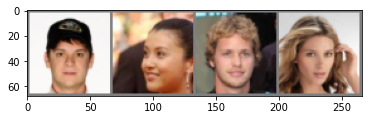

In [8]:
data_loader_sample = torch.utils.data.DataLoader(dataset=dataset, 
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(data_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

### Utils 
* Use the below code for the convolutions or the upconvolutions

In [9]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
    
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

### 2.1 Write the code (Generator) [4 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [13]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
cfg_g = [[], [], [], [], []]


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        #############
        # define upconvolution layers based on given configuration parameters
        self.upconv1 = upconv2d([100, 512, (4, 4), (1, 1), (0, 0), 'ReLU'])
        self.upconv2 = upconv2d([512, 256, (4, 4), (2, 2), (1, 1), 'ReLU'])
        self.upconv3 = upconv2d([256, 128, (4, 4), (2, 2), (1, 1), 'ReLU'])
        self.upconv4 = upconv2d([128, 64, (4, 4), (2, 2), (1, 1), 'ReLU'])
        self.upconv5 = upconv2d([64, 3, (4, 4), (2, 2), (1, 1), 'Tanh'], False)
        #############
        
    def forward(self, x):
        
        #############
        # reshape the input (latent vector z) to a computable size for upconvolution
        x = x.view(-1, 100, 1, 1)
        # forward each upconvolution layers
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.upconv5(x)
        
        return x
        #############
        

STEP 3-1: CREATE MODEL CLASS (Generator)


### 2.2 Write the code (Discriminator) [4 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [14]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
cfg_d = [[], [], [], [], []]


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #############
        # define convolution layers based on given configuration parameters
        self.conv1 = conv2d([3, 64, (4, 4), (2, 2), (1, 1), 'ReLU'])
        self.conv2 = conv2d([64, 128, (4, 4), (2, 2), (1, 1), 'ReLU'])
        self.conv3 = conv2d([128, 256, (4, 4), (2, 2), (1, 1), 'ReLU'])
        self.conv4 = conv2d([256, 512, (4, 4), (2, 2), (1, 1), 'ReLU'])
        self.conv5 = conv2d([512, 1, (4, 4), (1, 1), (0, 0), 'Sigmoid'], False)
        #############
        
    def forward(self, x):
        
        #############
        # forward each upconvolution layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x
        #############
        

STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [15]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G = Generator()
model_D = Discriminator()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G.to(device)
print(model_G)
model_D.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator(
  (upconv1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_

In [16]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.BCELoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the DCGAN [2 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
[0/5][400/1582]	Loss_D: 0.3958	Loss_G: 7.3284	
[0/5][800/1582]	Loss_D: 0.3978	Loss_G: 3.9455	
[0/5][1200/1582]	Loss_D: 0.3295	Loss_G: 3.9828	
[1/5][400/1582]	Loss_D: 0.2174	Loss_G: 6.0067	
[1/5][800/1582]	Loss_D: 2.1826	Loss_G: 2.0644	
[1/5][1200/1582]	Loss_D: 0.2816	Loss_G: 4.4860	
[2/5][400/1582]	Loss_D: 0.3136	Loss_G: 4.4249	
[2/5][800/1582]	Loss_D: 0.6343	Loss_G: 1.3940	
[2/5][1200/1582]	Loss_D: 0.5525	Loss_G: 2.2526	
[3/5][400/1582]	Loss_D: 0.4202	Loss_G: 5.9977	
[3/5][800/1582]	Loss_D: 0.1573	Loss_G: 3.1973	
[3/5][1200/1582]	Loss_D: 0.3944	Loss_G: 2.1820	
[4/5][400/1582]	Loss_D: 1.5729	Loss_G: 6.9268	
[4/5][800/1582]	Loss_D: 0.6237	Loss_G: 5.7703	
[4/5][1200/1582]	Loss_D: 0.1751	Loss_G: 4.4489	


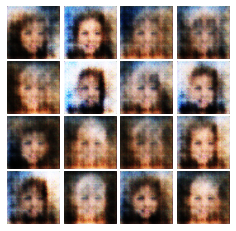

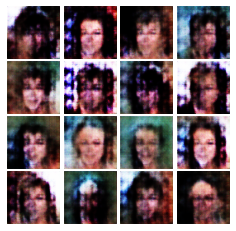

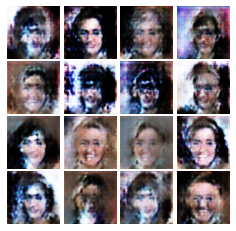

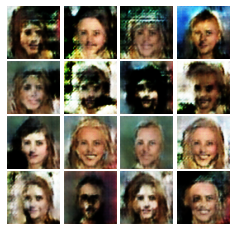

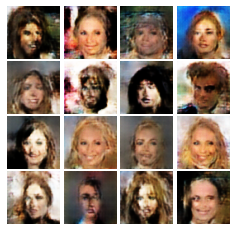

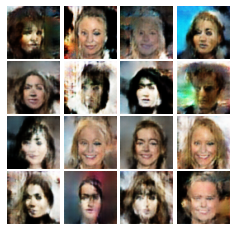

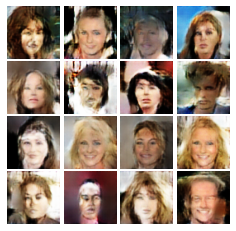

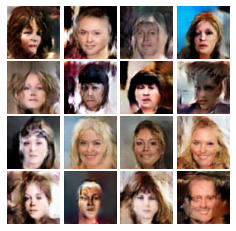

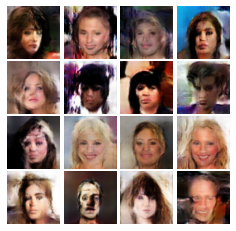

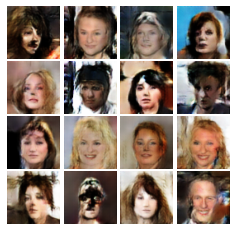

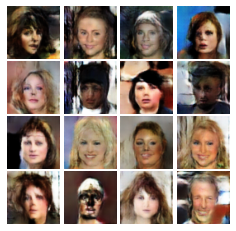

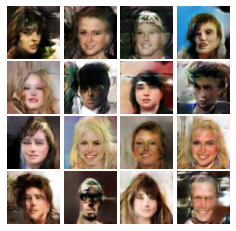

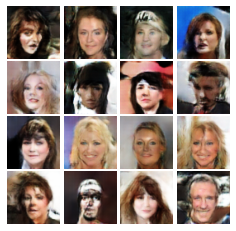

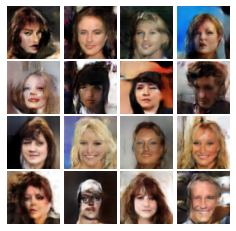

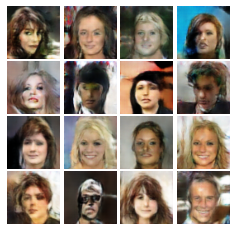

In [17]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3), cmap='Greys_r')
    return fig

print('STEP 7: TRAIN THE MODEL')

label_real = torch.full((bs,), real_label, device=device, dtype=torch.float)
label_fake = torch.full((bs,), fake_label, device=device, dtype=torch.float)

#  The input noise for inference
fixed_noise = torch.randn(bs, z_size, 1, 1, device=device, dtype=torch.float)


for epoch in range(num_epochs):
    
    model_G.train()
    model_D.train()
    
    for i, data in enumerate(data_loader):
        
        data = data[0].to(device)
        
        ### Update discriminator model
        
        # Clear gradients w.r.t. parameters
        model_D.zero_grad()
        
        # Forward pass to get results of discriminator for real data
        output_D_real = model_D(data).view(-1)
        
        # Calculate Loss
        err_D_real = criterion(output_D_real, label_real)
        
        # Generating noise inputs for generating fake samples
        noise = torch.randn(bs, z_size, 1, 1, device=device)
        
        # Forward pass to get generated samples
        output_G = model_G(noise)
        
        # Forward pass to get results of discriminator for fake data
        output_D_fake = model_D(output_G.detach()).view(-1)
        
        # Calculate Loss
        err_D_fake = criterion(output_D_fake, label_fake)
        
        # Combine the losses for real data and fake data
        err_D = err_D_real + err_D_fake
        
        # Getting gradients w.r.t. parameters
        err_D.backward()
        
        # Updating parameters
        optimizer_D.step()
        
        
        ### Update generator model
        
        # Clear gradients w.r.t. parameters
        model_G.zero_grad()
        
        # Forward pass to get results of discriminator for fake data
        output_G_real = model_D(output_G).view(-1)
        
        # Calculate Loss
        err_G = criterion(output_G_real, label_real)
        
        # Getting gradients w.r.t. parameters
        err_G.backward()
        
        # Updating parameters
        optimizer_G.step()
        
        # Output training stats
        if i % 400 == 0 and i != 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(data_loader),
                     err_D.item(), err_G.item()))

            model_G.eval()
            model_D.eval()
            with torch.no_grad():
                output = model_G(fixed_noise).detach().cpu().numpy()
                output = np.transpose((output+1)/2, (0, 2, 3, 1))
                fig = plot(output[:16])
                
            model_G.train()
            model_D.train()
         

# Discussion
- DCGAN의 Generator와 Discriminator model을 구현한 후 각 모델들을 이용하여 DCGAN을 학습시키고 매 epoch 당 400 iteration마다 모델들의 loss값과 학습된 모델이 생성하는 예측 결과를 출력해 보았다. 
- 전반적으로 보았을 때, Discriminator의 loss가 감소할 때 Generator의 loss는 증가하고, 그 반대의 경우 역시 마찬가지로 하는 패턴이 반복적으로 나타났다. 
- 이러한 패턴은 discriminator의 성능이 상대적으로 더 좋아져서 true/false 구분을 잘 하게 된다는 것은 generator가 discriminator를 속일 정도의 결과를 만들지 못함을 의미하기 때문에 discriminator의 loss는 증가, generator의 loss는 감소하는 것으로 나타난다는 사실을 반영한다. 마찬가지로, generator의 성능이 상대적으로 더 좋아지면 discriminator는 true/false 구분을 잘 하지 못하게 되므로 discriminator의 loss는 감소, generator의 loss는 증가하는 패턴을 보인다. 이는 discriminator와 generator의 경쟁 구도로 학습이 진행된다는 점에서 본다면 매우 타당한 해석이 된다. 
- 한편, Discriminator와 Generator의 loss는 training epoch가 반복됨에 따라 증감을 반복하며 더욱 작은 값으로 다가간다는 사실을 정량적으로 확인할 수 있다. 이는 학습이 거듭될수록 discriminator와 generator의 성능이 서로 향상되는 결과를 낳으면서, 결국 generator가 생성하는 false image의 품질을 향상시킨다. 
- 이렇게 개선된 generator의 false image output을 매 epoch에서 400 iteration마다 출력한 결과, training을 거듭할수록 generator의 성능이 향상되며 더욱 실제와 가까운 사람 얼굴이 생성되는 것을 정성적으로 확인할 수 있다. 육안으로 봤을 때 전반적으론 생성된 얼굴의 실제와의 유사도는 증가하는 것을 볼 수 있지만, 얼굴의 형상이 어색하고 삐뚤어진 경우가 존재함을 알 수 있다. 
- GAN 알고리즘의 특성 상 generator의 성능은 discriminator의 성능에 의존적일 수밖에 없는데, discriminator의 성능이 아무리 향상되더라도 사람의 식별 능력을 능가하지는 못하기 때문에 generator의 성능 향상에 한계가 있는 것으로 보인다. 

### *References*
[1] Radford et al., "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial network", *ICLR*, 2016. <br>
[2] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010 <br>